# gdgtm regression test

The goal of this test is to evaluate whether the gdgtm (**g**eospatial **d**ata **g**etting, **t**ransforming, **m**anaging) pipeline built to feed standardized rasters for downstream ML actions (overall goal of the gdgtm package) is working as intended. The test script is structured as follows:

- Section 1: Test the flow of the relevant "get" functions
- Section 2: Test the core pipeline for creating the "master" raster
- Section 3: Test the mosaics and raster combination components
- Section 4: Test the alignment and validation line
- Section 5: STAC get functions
- Section 6: Shapefile conversion
- Section 7: Numpyifying rasters

This is the test script and not intended as primary documentation ' for that, please refer to the "documentation" folder and the demo.

Current tested version: **0.7.0**

In [1]:
import gdgtm
import rasterio
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
import re
import shutil
import glob

## Test preparation
This section sets up the directory structure for the test script. This ensures the removal of any old test material, clearing any old structures and putting in new ones.

In [2]:
## Set up the test directory urls
test_location = "/home/pete/Documents/tests_and_vals" ## Change to local spec
test_directory = "gdgtm_test"

test_path = os.path.join(test_location, test_directory)
test_tifs = os.path.join(test_path, "test_tifs")

subdir_names = ["01_get_functions", "02_single_rescaled", 
                "03_single_to_zero_one", "04_single_landmasked", 
                "05_single_rebound", "06_single_reprojected", 
                "07_single_remove_nodata", "08_automated_from_blank", 
                "09_automated_from_coord", "10_automated_from_random", 
                "11_conversions"]


# subdir_names = ["01_get_functions", "02_single_reprojected", 
#                 "03_single_rescaled", "04_single_rebound", 
#                 "05_complimentary_aligned", "06_mosaic_merge_prep", 
#                 "07_mosaic_merge_out", "08_bound_shapefiles",
#                 "09_rasters_from_shp", "10_rasters_from_numpy"] ### SOME OF THESE WILL NEED FUNCTIONALITY REINSTATEMENT FIRST

In [3]:
### Function for deleting directory contents

def delete_dir_contents (directory):
    files = os.listdir(directory)
    for file in files:
        filepath = os.path.join(directory + "/", file)
        os.remove(filepath)

    return print(os.listdir(directory))


In [4]:
## Run the deletions
for name in subdir_names:
    subdir_path = os.path.join(test_path, name)
    if os.path.exists(subdir_path):
        items_in_subdir = len(os.listdir(subdir_path))
        if items_in_subdir > 0:
            delete_dir_contents(subdir_path)
            print(f"Deleted {items_in_subdir} from the sub-directory {name}")
        else:
            print(f"Sub-directory {name} is empty")
        os.rmdir(subdir_path)
        print(f"Deleted {subdir_path}")

# os.rmdir(test_path)

[]
Deleted 3 from the sub-directory 01_get_functions
Deleted /home/pete/Documents/tests_and_vals/gdgtm_test/01_get_functions
[]
Deleted 1 from the sub-directory 02_single_rescaled
Deleted /home/pete/Documents/tests_and_vals/gdgtm_test/02_single_rescaled
[]
Deleted 1 from the sub-directory 03_single_to_zero_one
Deleted /home/pete/Documents/tests_and_vals/gdgtm_test/03_single_to_zero_one
[]
Deleted 1 from the sub-directory 04_single_landmasked
Deleted /home/pete/Documents/tests_and_vals/gdgtm_test/04_single_landmasked
Sub-directory 05_single_rebound is empty
Deleted /home/pete/Documents/tests_and_vals/gdgtm_test/05_single_rebound
Sub-directory 06_single_reprojected is empty
Deleted /home/pete/Documents/tests_and_vals/gdgtm_test/06_single_reprojected
Sub-directory 07_single_remove_nodata is empty
Deleted /home/pete/Documents/tests_and_vals/gdgtm_test/07_single_remove_nodata
Sub-directory 08_automated_from_blank is empty
Deleted /home/pete/Documents/tests_and_vals/gdgtm_test/08_automated_f

In [5]:
## Re-build the test location structure

# os.mkdir(test_path)

for name in subdir_names:
    os.mkdir(os.path.join(test_path, name))

## Section 1: "get" function tests

**NOT TESTED IN 0.7.0 Need to reinstate with rasterio first**

In [6]:
## Copy test files from test_files to 01_get_functions

get_subdir = os.path.join(test_path, subdir_names[0])
shutil.copytree(test_tifs, get_subdir, dirs_exist_ok=True)

'/home/pete/Documents/tests_and_vals/gdgtm_test/01_get_functions'

## Section 2: transforming a single geotif

This section covers transformations of a single geotif

In [7]:
### Create the directories
rescale_subdir = os.path.join(test_path, subdir_names[1])
zero_oned_subdir = os.path.join(test_path, subdir_names[2])
landmasked_subdir = os.path.join(test_path, subdir_names[3])
rebound_subdir = os.path.join(test_path, subdir_names[4])
reproject_subdir = os.path.join(test_path, subdir_names[6])
nodata_subdir = os.path.join(test_path, subdir_names[7])

single_test_file = "CHELSA_bio1_1981-2010_V.2.1.tif"

print("subdirs created!")

# gdgtm.plot_raster_with_colorbar(
#     os.path.join(get_subdir, single_test_file),
#     title = "Base test file"
# )

subdirs created!


### change_raster_resolution

In [8]:
### change_raster_resolution (1): failure - provide invalid value for target res
rescale_src = os.path.join(get_subdir, single_test_file)
rescale_dst = os.path.join(rescale_subdir, single_test_file)


try:
    test = gdgtm.change_raster_res(target_res = "five hundred",
                                   src_raster = rescale_src,
                                   dst_raster = rescale_dst)
    print(test)
    gdgtm.plot_raster_with_colorbar(rescale_dst, title = "Rescaled file")
except Exception as e:
    print(f"Function failed to generate output: {e}")
    
print("Source file retained: " + str(os.path.exists(rescale_src)))
## Expected outcome: Error message, file retained

Function failed to generate output: unsupported operand type(s) for /: 'float' and 'str'
Source file retained: True


#### Test outcome

Results meet expectations

Resolution meets target, file exists: /home/pete/Documents/tests_and_vals/gdgtm_test/02_single_rescaled/CHELSA_bio1_1981-2010_V.2.1.tif


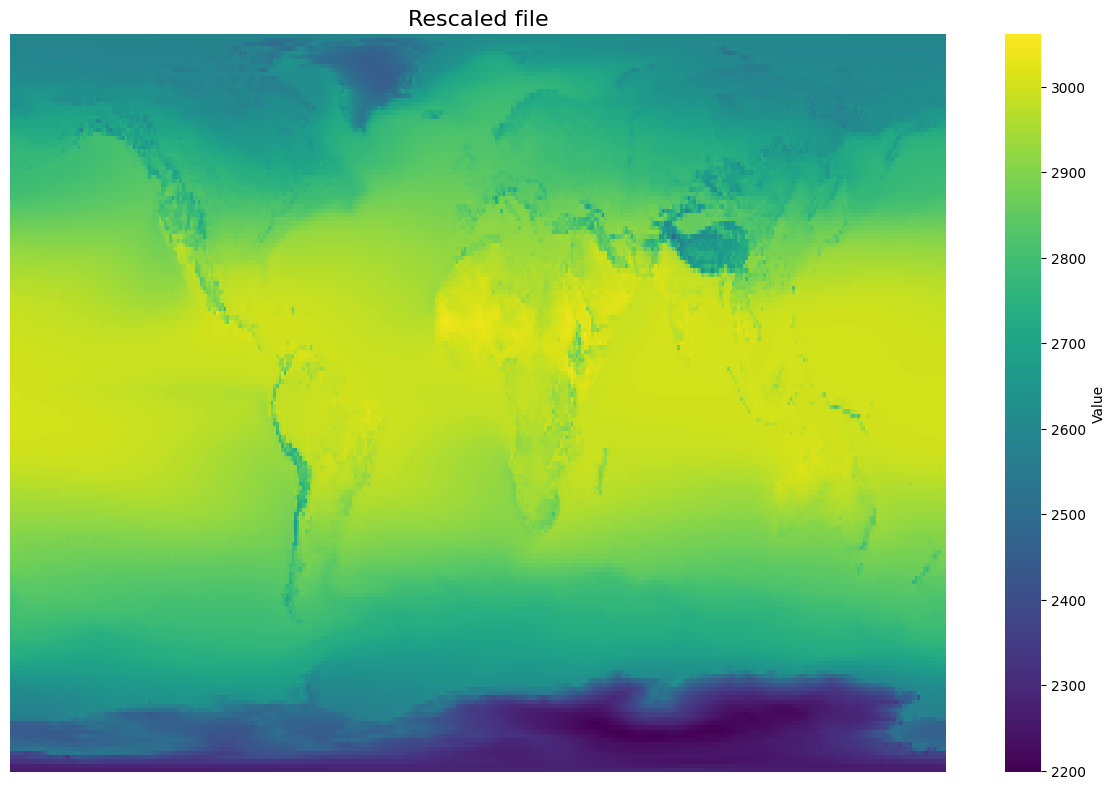

Source file retained: True


In [9]:
### change_raster_resolution (2): happy path - retain source raster

try:
    test = gdgtm.change_raster_res(target_res = 1,
                                   src_raster = rescale_src,
                                   dst_raster = rescale_dst)
    print(test)
    gdgtm.plot_raster_with_colorbar(rescale_dst, title = "Rescaled file")
except Exception as e:
    print(f"Function failed to generate output: {e}")
    
print("Source file retained: " + str(os.path.exists(rescale_src)))
## Expected outcome: Match confirmation ("Resolution change successful: new pixel size matches target"), file retained

#### Test outcome

Results match expectation

### rescale_raster_to_zero_one
This only covers the happy path. No internal checks built as yet into the functions (TODOs).

Rescaled raster saved to /home/pete/Documents/tests_and_vals/gdgtm_test/03_single_to_zero_one/CHELSA_bio1_1981-2010_V.2.1.tif
Original range: [2198.0, 3062.0] rescaled to [0, 1]
None


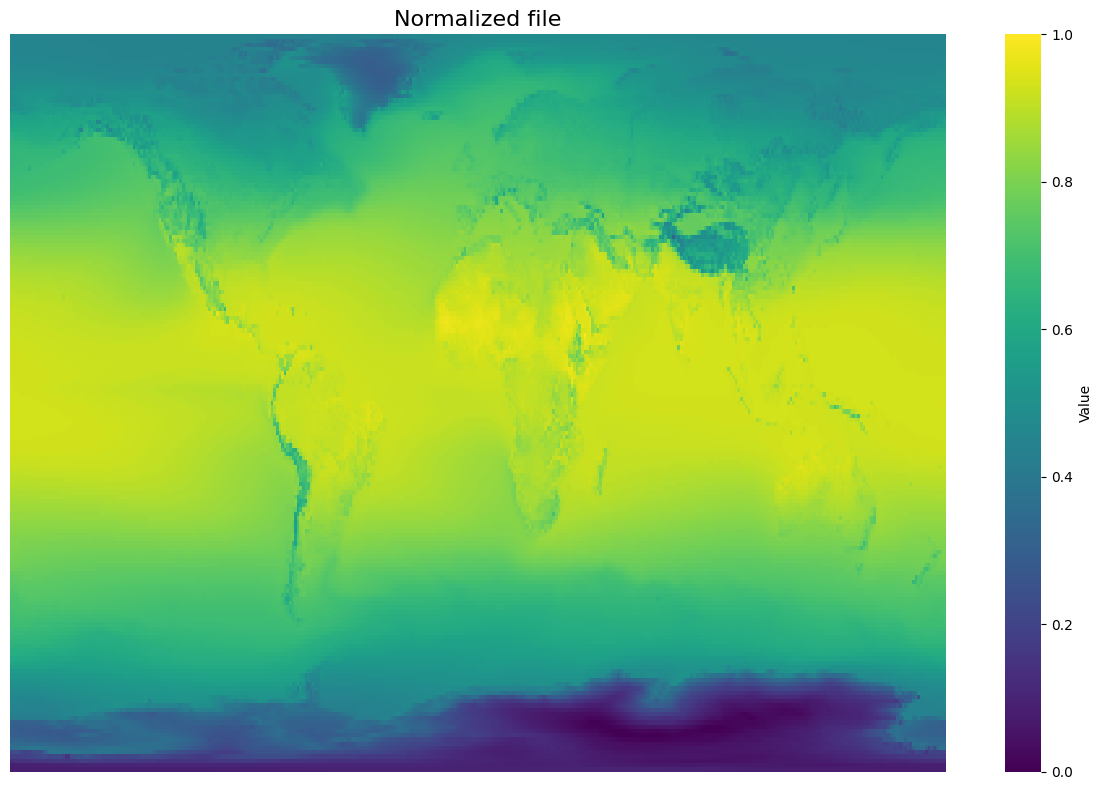

In [10]:
### rescale_raster_to_zero_one: happy path
norm_src = rescale_dst
norm_dst = os.path.join(zero_oned_subdir, single_test_file)

try:
    test = gdgtm.rescale_raster_to_zero_one(norm_src, norm_dst)
    print(test)
    gdgtm.plot_raster_with_colorbar(norm_dst, title = "Normalized file")    
except Exception as e:
    print(f"Function failed to generate output: {e}")

### apply_landmask
This only covers the happy path. No internal checks built as yet into the functions (TODOs).

Masked raster saved to /home/pete/Documents/tests_and_vals/gdgtm_test/04_single_landmasked/CHELSA_bio1_1981-2010_V.2.1.tif
None


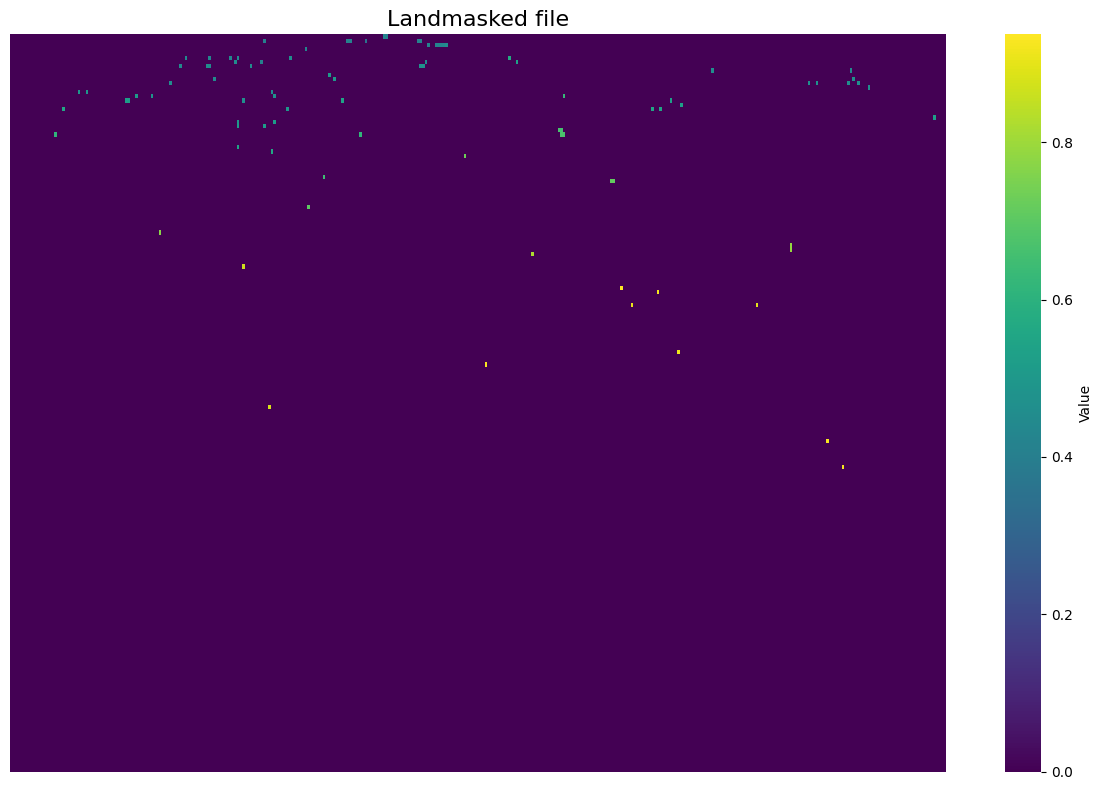

In [11]:
landmask = "hyd_glo_dem_30s.tif"
landmask = os.path.join(get_subdir, landmask)
land_src = norm_dst
land_dst = os.path.join(landmasked_subdir, single_test_file)

try:
    gdgtm.align_validate_raster(landmask, land_src, "temp_landmask.tif")
    test = gdgtm.apply_land_mask("temp_landmask.tif", land_src, land_dst)
    print(test)
    gdgtm.plot_raster_with_colorbar(land_dst, title = "Landmasked file")
except Exception as e:
    print(f"Function failed to generate output: {e}")
finally:
    os.remove("temp_landmask.tif")

### set_raster_boundbox

In [12]:
### set_raster_boundbox (1): failure - provide invalid bounding box
bbox_src = land_dst
bbox_dst = os.path.join(rebound_subdir, single_test_file)

new_bb = (50, 0, 0, 50) ### Error introduced on purpose: ESWN not WNES
try:
    test = gdgtm.set_raster_boundbox(target_bbox = new_bb,
                                     src_raster = bbox_src,
                                     dst_raster = bbox_dst,
                                     delete_source = False
                                     )
    print(test)
    gdgtm.plot_raster_with_colorbar(bbox_dst, title = "Rescaled file")
except Exception as e:
    print(f"Function failed to generate output: {e}")

print("Source file retained: " + str(os.path.exists(bbox_src)))
## Expected outcome: Error message, file retained

Function failed to generate output: set_raster_boundbox() got an unexpected keyword argument 'delete_source'
Source file retained: True


In [13]:
### set_raster_boundbox (2): happy path, retain source raster

new_bb = (0, 50, 50, 0)
try:
    test = gdgtm.set_raster_boundbox(target_bbox = new_bb,
                                     src_raster = bbox_src,
                                     dst_raster = bbox_dst)
    print(test)
    gdgtm.plot_raster_with_colorbar(bbox_dst, title = "Rescaled file")
except Exception as e:
    print(f"Function failed to generate output: {e}")

print("Source file retained: " + str(os.path.exists(bbox_src)))
## Expected outcome: Outcome message ("Warning, setting errors > 0.01 and file exists: /home/pete/Documents/tests_and_vals/gdgtm/04_master_rebound/chelsa_pr_rebound.tif"), source file retained

Function failed to generate output: 'tuple' object does not support item assignment
Source file retained: True


#### Test outcome

Results meet expectations.

### reproject_raster

In [14]:
### reproject_raster (1): error - provide faulty new_crs
reproj_src = bbox_dst
reproj_dst = os.path.join(reproject_subdir, single_test_file)

try:
    test = gdgtm.reproject_raster(new_crs = "ggplot:2", 
                                  src_raster = reproj_src,
                                  dst_raster = reproj_dst)
    print(test)
    gdgtm.plot_raster_with_colorbar(reproj_dst, title = "Rescaled file")
except Exception as e:
    print(f"Function failed to generate output: {e}")

print("Source file retained: " + str(os.path.exists(reproj_src)))
## Expected outcome: Error message, no file changes

Function failed to generate output: /home/pete/Documents/tests_and_vals/gdgtm_test/05_single_rebound/CHELSA_bio1_1981-2010_V.2.1.tif: No such file or directory
Source file retained: False


#### Test outcome

Results meet expectation

In [15]:
### reproject_raster (2): happy path

try:
    test = gdgtm.reproject_raster(new_crs = "ESRI:54028", 
                                  src_raster = reproj_src,
                                  dst_raster = reproj_dst)
    print(test)
    gdgtm.plot_raster_with_colorbar(reproj_dst, title = "Rescaled file")
except Exception as e:
    print(f"Function failed to generate output: {e}")

print("Source file retained: " + str(os.path.exists(reproj_src)))
## Expected outcome: new file confirmation message ("Reprojection successful"), confirm that source_file retained

Function failed to generate output: /home/pete/Documents/tests_and_vals/gdgtm_test/05_single_rebound/CHELSA_bio1_1981-2010_V.2.1.tif: No such file or directory
Source file retained: False


#### Test outcome

Results meet expectations

### replace_nodata_with_lowest
This only covers the happy path. No internal checks built as yet into the functions (TODOs).

In [16]:
### rescale_raster_to_zero_one: happy path
nodata_src = reproj_dst
nodata_dst = os.path.join(zero_oned_subdir, single_test_file)

try:
    test = gdgtm.replace_nodata_with_lowest(nodata_src, nodata_dst)
    print(test)
    gdgtm.plot_raster_with_colorbar(nodata_dst, title = "Nodata replaced by zeroes")    
except Exception as e:
    print(f"Function failed to generate output: {e}")

Function failed to generate output: /home/pete/Documents/tests_and_vals/gdgtm_test/07_single_remove_nodata/CHELSA_bio1_1981-2010_V.2.1.tif: No such file or directory


## Section 3: automated process from blank

### Section 3.1 Component functions test

### set_up_blank
This only covers the happy path. No internal checks built as yet into the functions (TODOs).

{'driver': 'GTiff', 'width': 250, 'height': 250, 'count': 1, 'dtype': 'uint16', 'crs': CRS.from_epsg(4326), 'transform': Affine(0.2, 0.0, 50.0,
       0.0, -0.2, 50.0), 'nodata': 1, 'tiled': True, 'compress': 'lzw'}
['EPSG:4326', [50.0, 0.2, 0.0, 50.0, 0.0, -0.2, 0.0, 0.0, 1.0]]


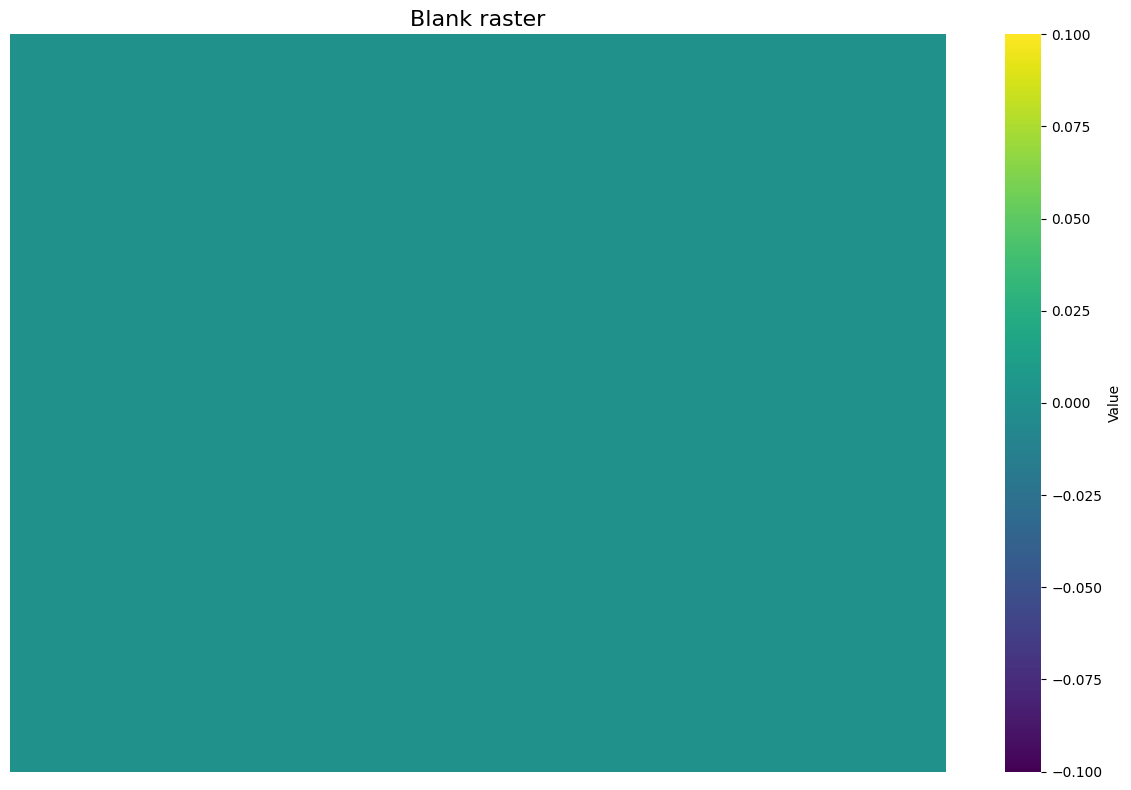

In [17]:
blank_dst = os.path.join(test_path, subdir_names[8], "test_blank1.tif")
bbox = (50, 50, 100, 0)
proj = "EPSG:4326"
pixel_size = 0.2

try:
    test = gdgtm.set_up_blank(bbox, proj, pixel_size, blank_dst)
    print(test)
    gdgtm.plot_raster_with_colorbar(blank_dst, title = "Blank raster")
except Exception as e:
    print(f"Function failed to generate output: {e}")   

### get_proj_transform
This only covers the happy path. No internal checks built as yet into the functions (TODOs).

In [18]:
try:
    test = gdgtm.get_proj_transform(blank_dst)
    print(test)
except Exception as e:
    print(f"Function failed to generate output: {e}") 

Function failed to generate output: module 'gdgtm' has no attribute 'get_proj_transform'


### check_if_geotif
This only covers the happy path. No internal checks built as yet into the functions (TODOs).

In [19]:
try:
    test = gdgtm.check_if_geotiff(blank_dst)
    print(test)
except Exception as e:
    print(f"Function failed to generate output: {e}") 

Function failed to generate output: module 'gdgtm' has no attribute 'check_if_geotiff'


### align_raster
This only covers the happy path. No internal checks built as yet into the functions (TODOs).

/home/pete/Documents/tests_and_vals/gdgtm_test/09_automated_from_coord/aligned.tif exists


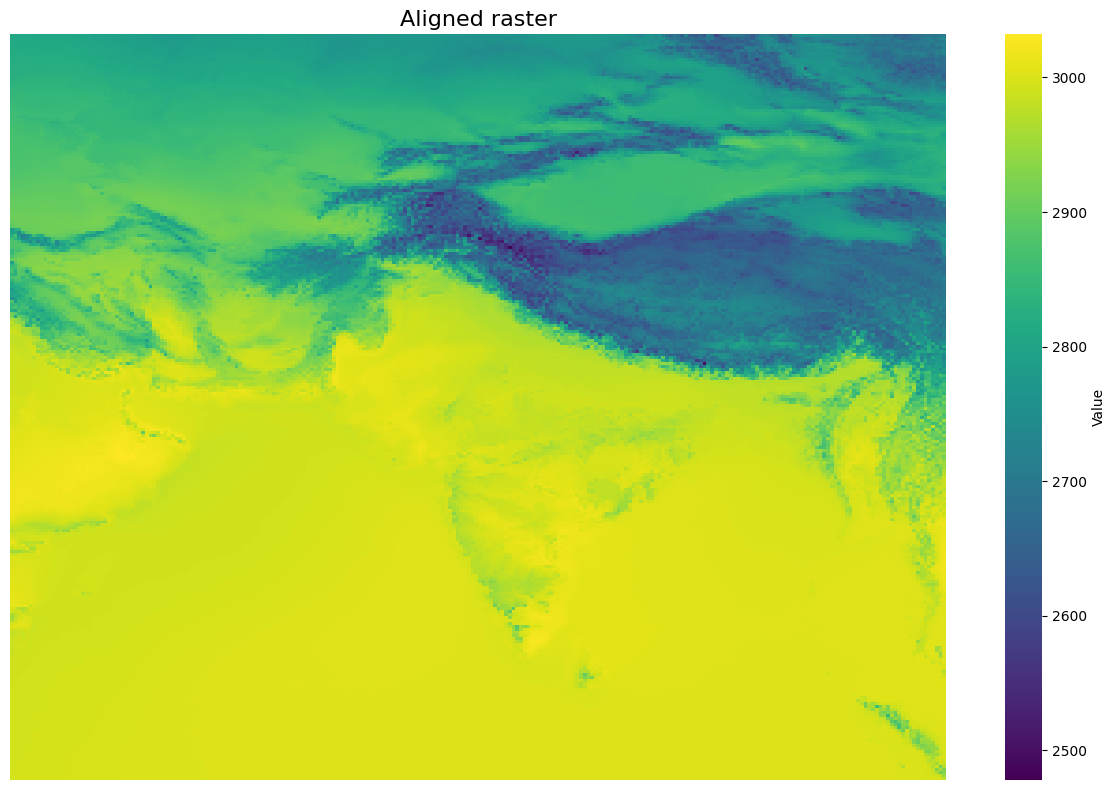

In [20]:
align_src = os.path.join(get_subdir, single_test_file)
align_dst = os.path.join(test_path, subdir_names[8], "aligned.tif")

try:
    test = gdgtm.align_raster(src_raster = align_src,
                              target_raster = blank_dst,
                              dst_raster = align_dst)
    print(test)
    gdgtm.plot_raster_with_colorbar(align_dst, title = "Aligned raster")
except Exception as e:
    print(f"Function failed to generate output: {e}")

### validate_raster_alignment
This only covers the happy path. No internal checks built as yet into the functions (TODOs).

In [21]:
try:
    test = gdgtm.validate_raster_alignment(align_dst, blank_dst)
    print(test)
except Exception as e:
    print(f"Function failed to generate output: {e}")    

{'dimension_match': True, 'projection_match': True, 'pixel_count_match': True, 'geotransform_match': True}


### align_validate_raster
This only covers the happy path. No internal checks built as yet into the functions (TODOs).

In [22]:
align_validated_dst = os.path.joinos.path.join(test_path, subdir_names[8], "aligned_validated.tif")

try:
    test = gdgtm.align_validate_raster(align_src, blank_dst, align_validated_dst)
    print(test)
    gdgtm.plot_raster_with_colorbar(align_validated_dst, title = "Aligned raster")
except Exception as e:
    print(f"Function failed to generate output: {e}")    

AttributeError: module 'posixpath' has no attribute 'joinos'

### Section 3.2 align_rasters
This function takes on multiple rasters and aligns them on the bbox provided
This only covers the happy path. No internal checks built as yet into the functions (TODOs).

In [ ]:
bbox = (0, 2000000, 2000000, 0)
proj = "ESRI:54028"
pixel_size = 10000
blank_dst = os.path.join(test_path, subdir_names[8], "test_blank2.tif")

src_rasters = glob.glob(os.path.join(get_subdir, "*.tif"))
print(src_rasters)

dst_rasters = []

for raster in src_rasters:
    dst_rasters.append(os.path.join(test_path, subdir_names[8], os.path.basename(raster)))

print(dst_rasters)

try:
    test =  gdgtm.align_rasters(bbox = bbox, 
                                proj = proj, 
                                pixel_size = pixel_size, 
                                dst_blank = blank_dst, 
                                src_rasters = src_rasters,
                                dst_rasters = dst_rasters)
    print(test)
    for raster in dst_rasters:
        gdgtm.plot_raster_with_colorbar(raster, title = f"{raster}")
except Exception as e:
    print(f"Function failed to generate output: {e}")

## Section 4: automated process from random coordinates
This only covers the happy path. No internal checks built as yet into the functions (TODOs).

In [ ]:
# random.seed(413)

# src_raster = os.path.join(get_subdir, single_test_file)

# for draw in range(10):
    


## Section 5: Conversions

### convert_gtif_to_nparray

In [ ]:
### convert_gtif_to_jpg

In [ ]:
### process_dir_to_jpg

## Section X: STAC and Chelsa get functions
**IN WAIT FOR RE_IMPLEMENT**

## Section X: Mosaics and Merging
**IN WAIT FOR RE_IMPLEMENT**

## Section X: Shapefile conversion
**IN WAIT FOR RE_IMPLEMENT**